 # Classification testing workflow

 ## Installation

  <pre>pip install pandas pingouin seaborn matplotlib scikit-learn</pre>

We need the development version of scikit-posthocs to get critical difference diagrams

  <pre>pip install git+https://github.com/maximtrp/scikit-posthocs.git</pre>



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from scipy.stats import levene
import sys
sys.path.append('..')

from model_comparison import calc_classification_metrics, make_ci_plot_grid, make_mcs_plot_grid, make_normality_diagnostic, make_boxplots_parametric, make_scatterplot, rm_tukey_hsd, make_curve_plots

In [5]:
biosynfoni_results = pd.read_csv('biosynfoni_keys_results.csv')
biosynfoni_results["method"] = "Biosynfoni"

dmpnn_results = pd.read_csv('dmpnn_results.csv')
dmpnn_results["method"] = "DMPNN"

neural_npfp = pd.read_csv('neural_npfp_results.csv')
neural_npfp["method"] = "NeuralNPFP"

np_classifier = pd.read_csv('np_classifier_fp_results.csv')
np_classifier["method"] = "NPClassifierFP"


results = pd.concat([biosynfoni_results, dmpnn_results, neural_npfp, np_classifier], ignore_index=True)

# from combined fold and rep create a new column called cv_cycle with an unique integer value
results["cv_cycle"] = results["rep"] 


results["split"] = "stratified multilabel split"
results

,Unnamed: 0,rep,f1,recall,precision,method,Unnamed: 0.1,cv_cycle,split
0,0.0,0,0.788792,0.784662,0.821492,Biosynfoni,NaN,0,stratified multilabel split
1,0.0,1,0.796298,0.792568,0.829814,Biosynfoni,NaN,1,stratified multilabel split
2,0.0,2,0.785159,0.779148,0.823939,Biosynfoni,NaN,2,stratified multilabel split
3,0.0,3,0.791558,0.790279,0.820029,Biosynfoni,NaN,3,stratified multilabel split
4,0.0,4,0.798728,0.793531,0.831554,Biosynfoni,NaN,4,stratified multilabel split
5,0.0,0,0.921686,0.907908,0.947730,DMPNN,NaN,0,stratified multilabel split
6,0.0,1,0.923462,0.912574,0.944427,DMPNN,NaN,1,stratified multilabel split
7,0.0,2,0.922995,0.913068,0.943915,DMPNN,NaN,2,stratified multilabel split
8,0.0,3,0.917881,0.904798,0.944262,DMPNN,NaN,3,stratified multilabel split
9,0.0,4,0.919392,0.907686,0.941711,DMPNN,NaN,4,stratified multilabel split


 ## 2. Calculate Classification Metrics

In [7]:

metric_ls = results.columns[2:5]
metric_ls


Index(['f1', 'recall', 'precision'], dtype='object')

Select the data generated from scaffold splits

## 4 Examine the parametric testing assumptions

#### 4.1 The independence assumption

There is no straight-forward way to test for this, which is why the usage of appropriate sampling mechanisms (such as 5x5 repeated CV) is so important to ensure the samples are sufficiently independent. There is dependency introduced by the same splits being used across methods, but the repeated measures ANOVA to TukeyHSD workflow accounts for this.

#### 4.2 The homogeneity of variances assumption

A typical rule of thumb is that the ratio of the largest and smallest variance should not be larger than 3. However, in the case of equally sized groups, much larger variance ratios are tolerated and these can be as high as 9 (see [here](https://link.springer.com/article/10.3758/s13428-017-0918-2)). Since the same number of CV iterations are performed for each model in 5x5 repeated CV, the groups are equally sized. This assumption will rarely be violated.

You can test for differences between variances using the Levene test. The Levene test is not significant for any metric. 

In [8]:
for metric in metric_ls:
    groups = results.groupby('method')[metric].apply(list)
    stat, pvalue = levene(*groups)
    print(f'Levene test for {metric}: p-value = {pvalue}')

Levene test for f1: p-value = 0.11186758495619314
Levene test for recall: p-value = 0.43186993076453384
Levene test for precision: p-value = 0.030539100510940758


In [9]:
variances_by_method = results.groupby('method')[metric_ls].var()
max_fold_diff = variances_by_method.max() / variances_by_method.min()
print(max_fold_diff)

f1           24.957067
recall       17.734454
precision    53.073190
dtype: float64


In [10]:
results.shape

(20, 9)

#### 4.3 The normality assumption

ANOVA and Tukey HSD will be robust to moderate normality violations for the 25 samples collected by 5x5 repeated CV. Note that only approximate normality of the data generating population distribution is assumed. It can be difficult to examine this when sample sizes are small. In these cases, an argument is often made on the conceptual level for approximate normality.   This argument can be made for performance metrics since they are typically the sum of many variables (e.g., the sum of individual errors) and will be approximately normal due to the Central Limit Theorem. Since 25 samples are collected from each distribution, one is able to check for strong violations of normality. The best way of doing this is by visualizing the distribution. We recommend against using tests for normality (e.g. Kolmogorov-Smirnov) as they will have low statistical power. See [here](https://www.researchgate.net/publication/11454445_The_Importance_of_the_Normality_Assumption_in_Large_Public_Health_Data_Sets) and [here](https://psycnet.apa.org/record/2018-24694-018) for a review of the robustness of ANOVA to non-normality. 


With 5x5 = 25 CV replicates it is clear that the performance metric distributions are sufficiently normally distributed to perform the ANOVA.

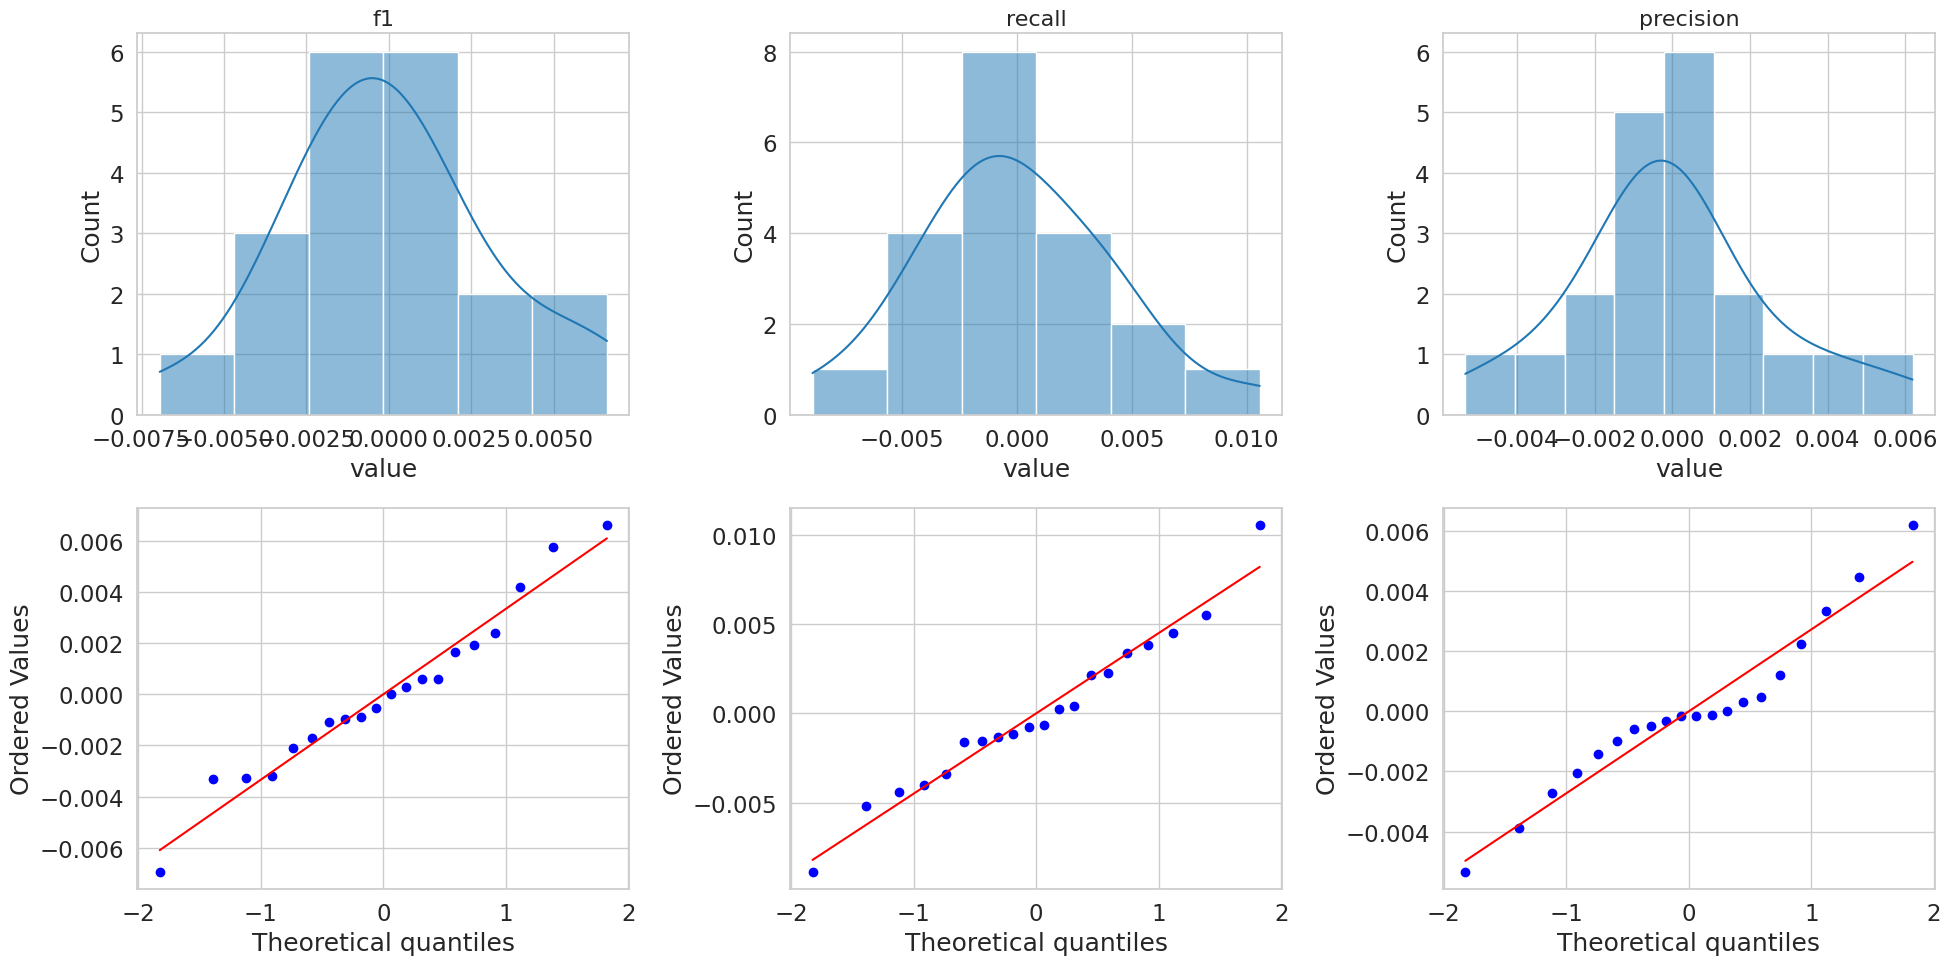

In [11]:
make_normality_diagnostic(results.copy(), metric_ls)

## 5. Perform repeated measures ANOVA

Since the assumptions were not violated, we proceed through the parametric testing workflow. We start with a test for whether there is any difference between groups. Since the methods are using the same splits, there is dependency in the samples. We account for this using a repeated measures ANOVA.

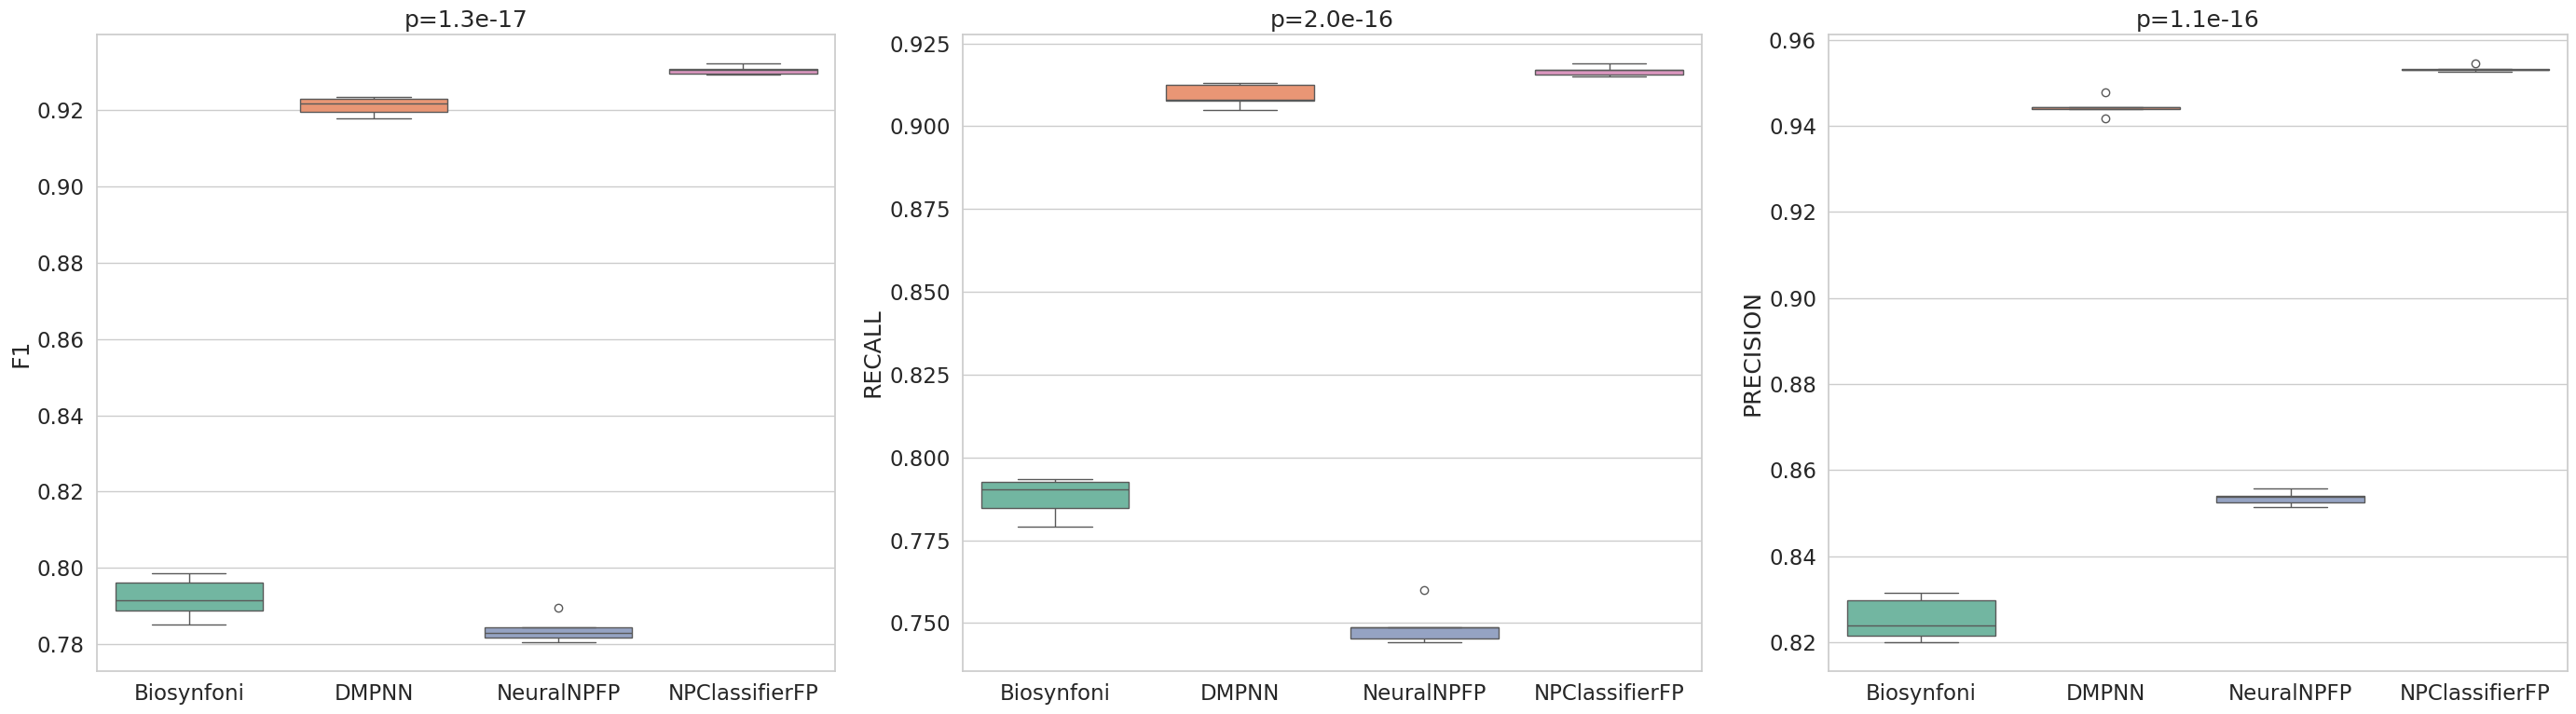

In [12]:
make_boxplots_parametric(results, metric_ls)

  ## 6. Perform a Post-Hoc Analysis to Examine Differences Between Methods

  The ANOVA test tells us **if** there is difference between three or more distributions, but it doesn't tell us **where** the difference is.  We can use post-hoc tests to look at individual differences.  Note that the p-value for the individual comparisons is corrected to account for multiple compararions. In this case we'll use Tukey's Honestly Significant Difference (HSD).

  ### 6.1 MCS Plots

In [13]:
metric_ls

Index(['f1', 'recall', 'precision'], dtype='object')

In [14]:
results.sort_values(by=['cv_cycle'])

,Unnamed: 0,rep,f1,recall,precision,method,Unnamed: 0.1,cv_cycle,split
0,0.0,0,0.788792,0.784662,0.821492,Biosynfoni,NaN,0,stratified multilabel split
5,0.0,0,0.921686,0.907908,0.947730,DMPNN,NaN,0,stratified multilabel split
15,0.0,0,0.932107,0.918875,0.954472,NPClassifierFP,0.0,0,stratified multilabel split
10,0.0,0,0.780608,0.745428,0.853957,NeuralNPFP,NaN,0,stratified multilabel split
6,0.0,1,0.923462,0.912574,0.944427,DMPNN,NaN,1,stratified multilabel split
11,0.0,1,0.789669,0.760000,0.852489,NeuralNPFP,NaN,1,stratified multilabel split
1,0.0,1,0.796298,0.792568,0.829814,Biosynfoni,NaN,1,stratified multilabel split
16,NaN,1,0.930446,0.917123,0.953106,NPClassifierFP,0.0,1,stratified multilabel split
2,0.0,2,0.785159,0.779148,0.823939,Biosynfoni,NaN,2,stratified multilabel split
12,0.0,2,0.781805,0.744266,0.855707,NeuralNPFP,NaN,2,stratified multilabel split


Creating 1 rows and 3 columns of plots for 3 stats.


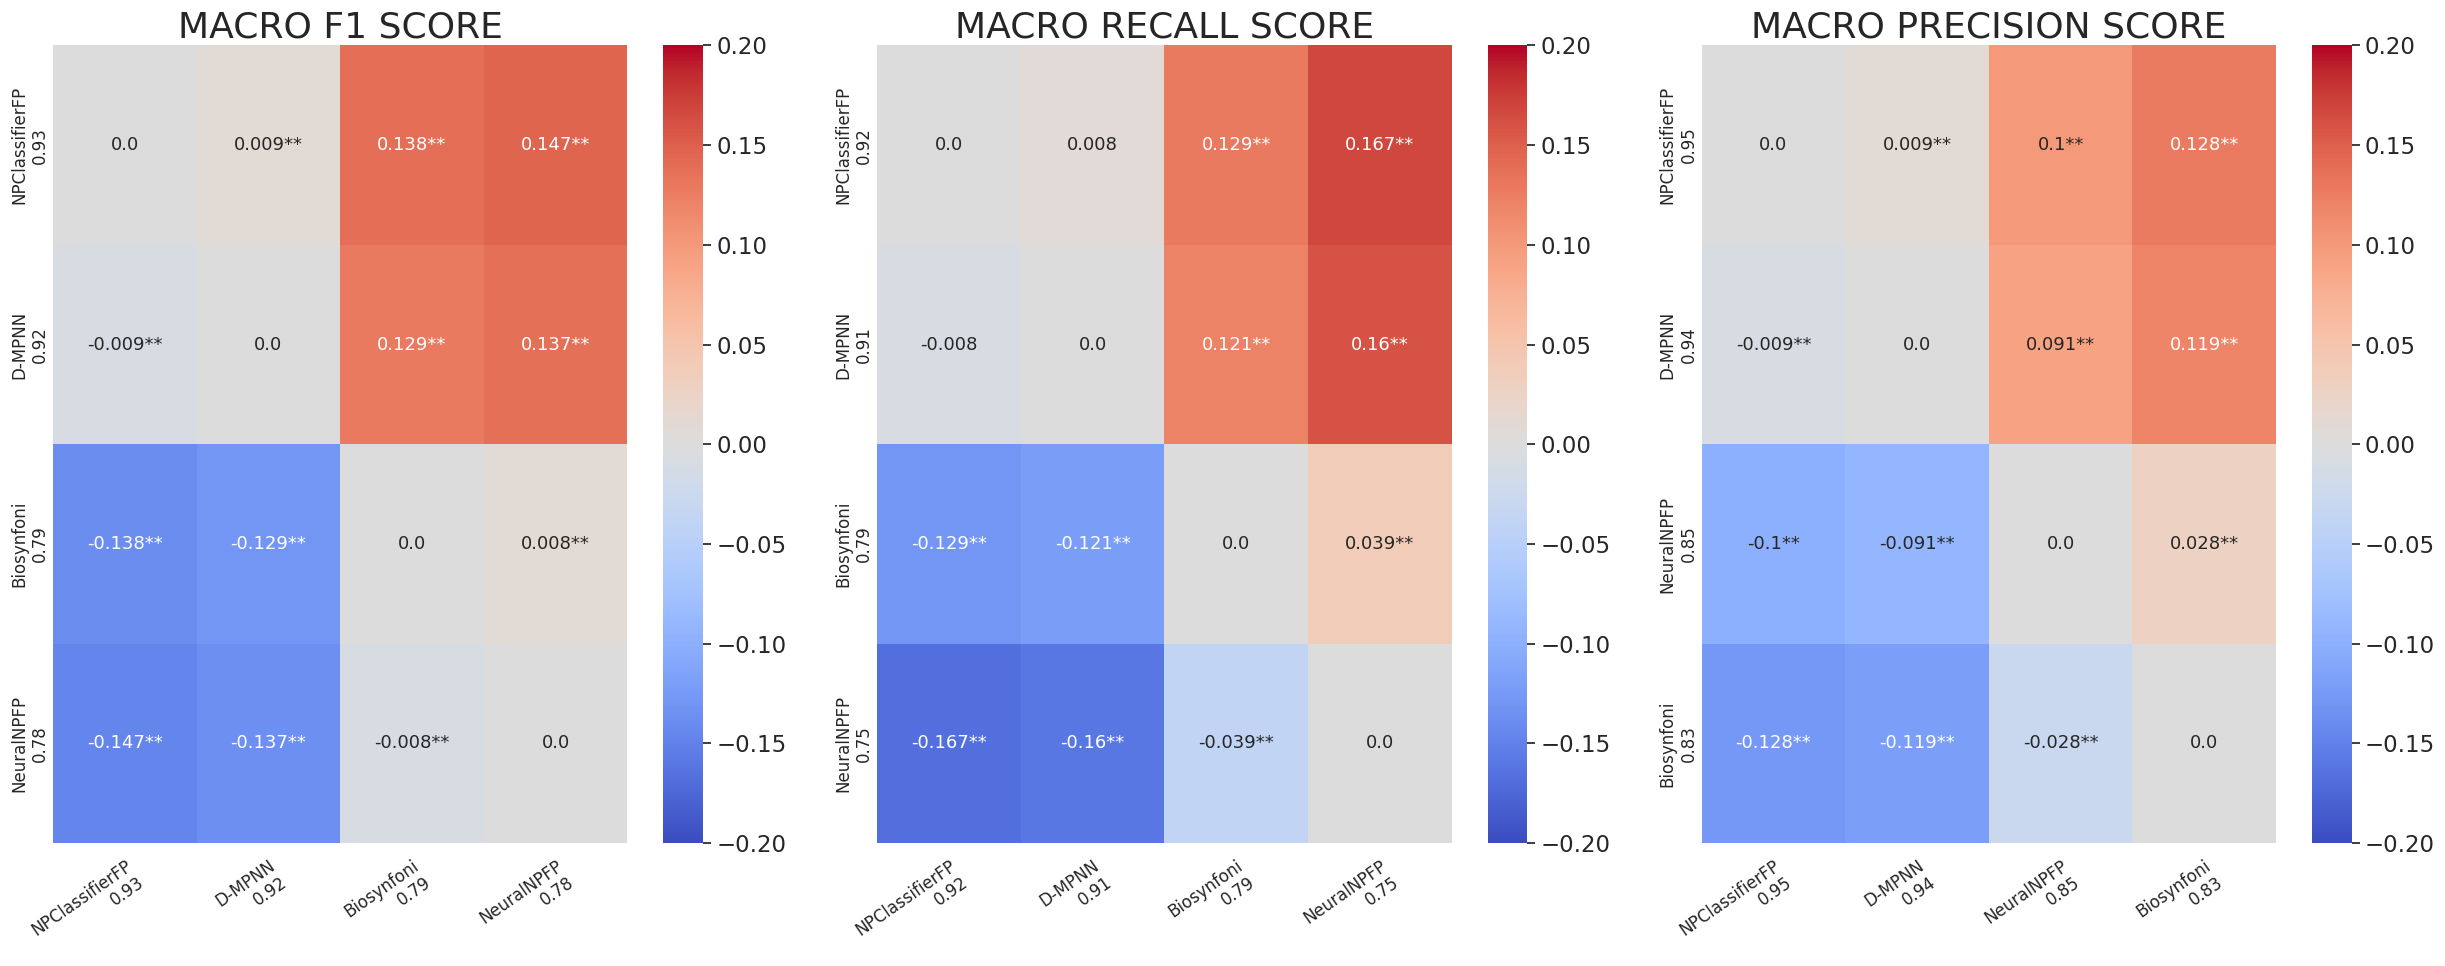

In [17]:
import pandas as pd
from scipy.stats import levene
import sys
sys.path.append('..')

from model_comparison import calc_classification_metrics, make_ci_plot_grid, make_mcs_plot_grid, make_normality_diagnostic, make_boxplots_parametric, make_scatterplot, rm_tukey_hsd, make_curve_plots
biosynfoni_results = pd.read_csv('biosynfoni_keys_results.csv')
biosynfoni_results["method"] = "Biosynfoni"

dmpnn_results = pd.read_csv('dmpnn_results.csv')
dmpnn_results["method"] = "D-MPNN"

neural_npfp = pd.read_csv('neural_npfp_results.csv')
neural_npfp["method"] = "NeuralNPFP"

np_classifier = pd.read_csv('np_classifier_fp_results.csv')
np_classifier["method"] = "NPClassifierFP"

results = pd.concat([biosynfoni_results, dmpnn_results, neural_npfp, np_classifier], ignore_index=True)

# from combined fold and rep create a new column called cv_cycle with an unique integer value
results["cv_cycle"] =  results["rep"] 

results["split"] = "stratified multilabel split"

results = results.rename(columns={'f1': 'macro f1 score', 'recall': 'macro recall score', 'precision': 'macro precision score'})
metric_ls = results.columns[2:5]

effect_dict = {'macro f1 score':.1, 'macro recall score':.1, 'macro precision score':.1}
direction_dict = {'macro f1 score':'maximize', 'macro recall score':'maximize', 'macro precision score':'maximize'}

make_mcs_plot_grid(results, metric_ls, group_col="method", effect_dict=effect_dict, direction_dict=direction_dict,
                   figsize=(25, 10), cell_text_size=13, axis_text_size=12, title_text_size=26, show_diff=True, sort_axes=True,
                   rotation_x=35, rotation_y=90)

#### 6.2 Examine if performance differences are actually meaningful by looking at ROC curves

Is the significant difference between the chemprop_mt and lightGBM large enough to be considered practically significant?

To examine this, we map the thresholds of interest on the ROC curve. The dotted vertical lines shows the threshold that maximizes recall subject to PPV > 80%.  The dashed vertical lines shows the threshold that maximizes TNR subject to NPV > 80%.



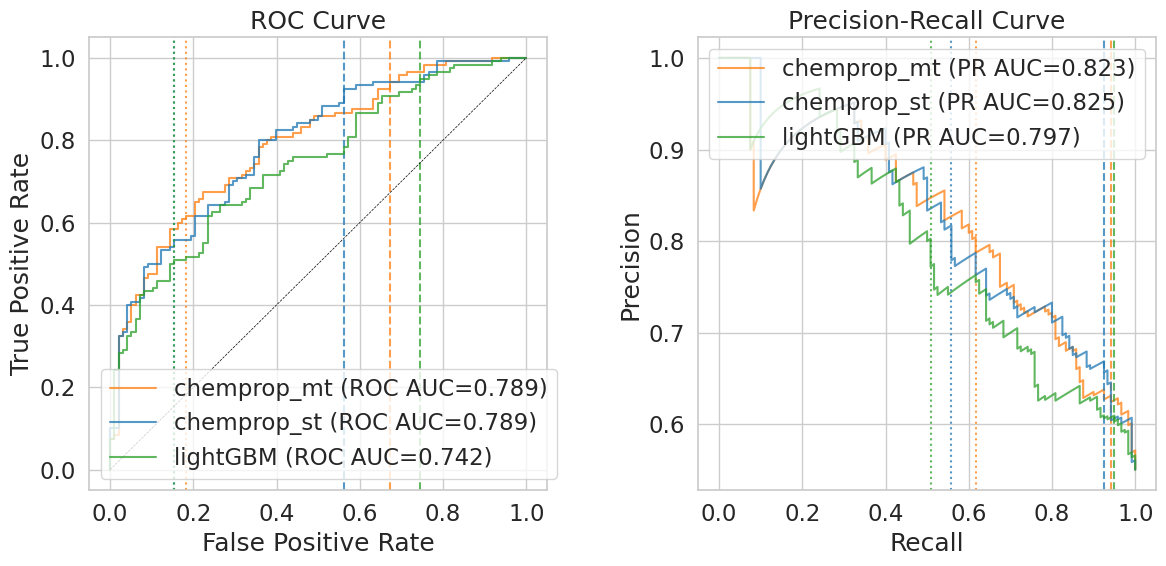

In [14]:
make_curve_plots(df_input)

## 7 Supplementary materials

### 7.1 Difference confidence intervals
You can use TukeyHSD to construct confidence intervals for the differences such that uncertainty in the difference estimate is accounted for. The plot below was adapted from [multicomp](https://cran.r-project.org/web/packages/multcomp/vignettes/generalsiminf.pdf) in R. Intervals that do not cross the zero line imply statistical significance. 

As the number of comparisons gets large, the number of pairwise comparisons will become difficult to visualize in one plot. We therefore recommend providing these results in the supplementary as either a plot or tabular form. Alternatively, you may find it optimal to only show a few differences of interest. But remember to apply the TukeyHSD to all comparisons that were examined originally, to avoid [data dredging](https://en.wikipedia.org/wiki/Data_dredging).

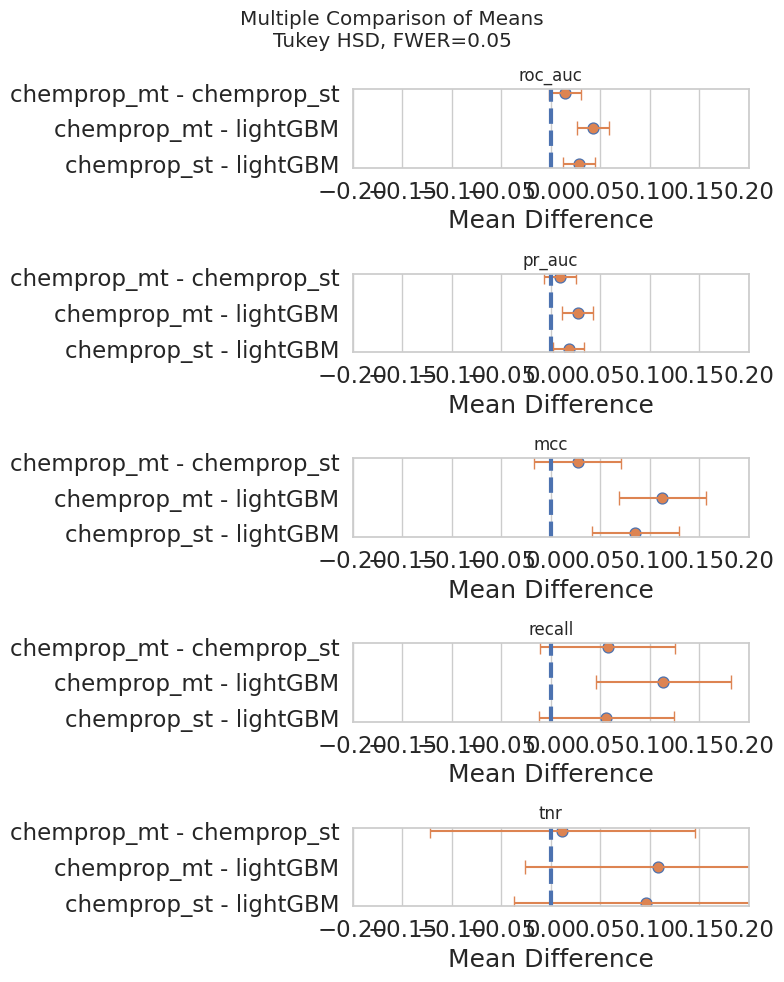

In [15]:
make_ci_plot_grid(df_scaffold_split, metric_ls, "method")